We want to predict the customer churn rate of a company in order to stop them from churning via deals/discounts. We need to be able to identify who are likely to churn.

We approach this via binary classification. Likelihood of churn is a value between 0 (not at all ) to 1 (100% likely to churn).

We build a model using existing customers' data.

In [115]:
import numpy as np
import pandas as pd

### Data Preparation

In [116]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [117]:
!wget $data -O data-week-3.csv

--2025-10-10 19:57:30--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data-week-3.csv’

data-week-3.csv     100%[===================>] 954.59K  --.-KB/s    in 0.009s  

2025-10-10 19:57:31 (98.9 MB/s) - ‘data-week-3.csv’ saved [977501/977501]



In [118]:
df = pd.read_csv('data-week-3.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [119]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [120]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce').fillna(0)
#nan represented as ' ' in this dataset (so now as '_'). To correct this use errors='coerce', which makes them na. Then we replace them with 0

In [121]:
df.totalcharges.isnull().sum()

np.int64(0)

In [122]:
(df.churn == 'yes').astype(int).head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

In [123]:
df.churn = (df.churn == 'yes').astype(int)

### Setting up validation framework

This time using scikit-learn instead of doing this manually

In [124]:
from sklearn.model_selection import train_test_split

In [125]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [126]:
len(df_full_train), len(df_test)

(5634, 1409)

In [127]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [128]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [129]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [130]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [131]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

### EDA

Check missing values, look at target variable, look at numerical and categorical variables

In [132]:
df_full_train = df_full_train.reset_index(drop=True)

In [133]:
df_full_train.churn.value_counts(normalize=True) #churn rate = 0.269968

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [134]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate, 2)

np.float64(0.27)

In [135]:
df_full_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [136]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [137]:
 categorical = [
    'gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 
    'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
    'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod'
 ]

In [138]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### Feature importance: Churn rate and risk ratio (still EDA)

Churn rate within each group

In [139]:
df_full_train.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [140]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_female, churn_male

(np.float64(0.27682403433476394), np.float64(0.2632135306553911))

In [141]:
global_churn = df_full_train.churn.mean()

In [142]:
df_full_train.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [143]:
churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
global_churn, churn_partner, churn_no_partner

(np.float64(0.26996805111821087),
 np.float64(0.20503330866025166),
 np.float64(0.3298090040927694))

In [144]:
global_churn - churn_partner, global_churn - churn_no_partner #partner variable is more important for churn prediciton than gender variable
#peoplee without partners are more likely to churn than global churn rate

(np.float64(0.06493474245795922), np.float64(-0.05984095297455855))

In [145]:
churn_no_partner / global_churn, churn_partner / global_churn
#risk ratio (churn_group / global_churn)
#if > 1 more likely to churn, < 1 less likely. This gives us churn metrics in relative rates, difference gives us just absolutes
#no partner group is a high risk group for churn

(np.float64(1.2216593879412643), np.float64(0.7594724924338315))

In [146]:
from IPython.display import display

In [147]:
for c in categorical:
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print()
    print()

,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


### Feature Importance: Mutual Information

Mutual information of two random variables is a measure of the mutual dependence between the two variables.
The higher mutual information is, the more relevant it is for churn

In [148]:
from sklearn.metrics import mutual_info_score

In [149]:
mutual_info_score(df_full_train.contract, df_full_train.churn)

0.0983203874041556

In [150]:
mutual_info_score(df_full_train.gender, df_full_train.churn) #much lower, we learn very little

0.0001174846211139946

In [151]:
#rank relative importance by mutual information score
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [152]:
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

### Feature importance: Correlation
Way to measure relation between numerical variables

In [153]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [154]:
df_full_train[numerical].corrwith(df_full_train.churn).abs()

tenure            0.351885
monthlycharges    0.196805
totalcharges      0.196353
dtype: float64

In [155]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

np.float64(0.5953420669577875)

In [156]:
df_full_train[df_full_train.tenure > 2].churn.mean()

np.float64(0.22478269658378816)

In [157]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean() 

np.float64(0.3994413407821229)

In [158]:
df_full_train[df_full_train.monthlycharges <= 20].churn.mean()

np.float64(0.08795411089866156)

In [159]:
df_full_train[(df_full_train.monthlycharges > 20) & (df_full_train.monthlycharges <= 50)].churn.mean()

np.float64(0.18340943683409436)

In [160]:
df_full_train[df_full_train.monthlycharges > 50].churn.mean()

np.float64(0.32499341585462205)

### One-hot encoding

Encode categorical variables using scikit-learn

In [161]:
from sklearn.feature_extraction import DictVectorizer

In [162]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

In [163]:
train_dicts[0]

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 72,
 'monthlycharges': 115.5,
 'totalcharges': 8425.15}

In [164]:
dv = DictVectorizer(sparse=False)

In [165]:
X_train = dv.fit_transform(train_dicts)

In [166]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

In [167]:
X_val = dv.transform(val_dicts) #don't need to transform on the validation dataset

### Logistic Regression

Sigmoid function applied to linear regression

sigmoid(w0 + wT.x_i) (sigmoid = s-shape with 0 < y < 1)

This is how we can convert a score (lin reg) to a probability

In [168]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [169]:
z = np.linspace(-5,5, 51)

In [170]:
sigmoid(z)

array([0.00669285, 0.00816257, 0.0099518 , 0.01212843, 0.01477403,
       0.01798621, 0.02188127, 0.02659699, 0.03229546, 0.03916572,
       0.04742587, 0.05732418, 0.06913842, 0.0831727 , 0.09975049,
       0.11920292, 0.14185106, 0.16798161, 0.19781611, 0.23147522,
       0.26894142, 0.31002552, 0.35434369, 0.40131234, 0.450166  ,
       0.5       , 0.549834  , 0.59868766, 0.64565631, 0.68997448,
       0.73105858, 0.76852478, 0.80218389, 0.83201839, 0.85814894,
       0.88079708, 0.90024951, 0.9168273 , 0.93086158, 0.94267582,
       0.95257413, 0.96083428, 0.96770454, 0.97340301, 0.97811873,
       0.98201379, 0.98522597, 0.98787157, 0.9900482 , 0.99183743,
       0.99330715])

In [171]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Sigmoid Function')

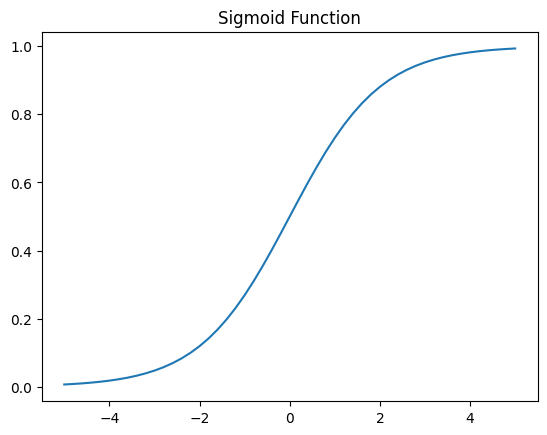

In [172]:
plt.plot(z, sigmoid(z))
plt.title("Sigmoid Function")

In [173]:
def linear_regression(xi):
    result = w0

    for j in range(len(w)):
        result = result + xi[j] * w[j]
    
    return result

In [174]:
def logistic_regression(xi):
    result = w0

    for j in range(len(w)):
        score = score + xi[j] * w[j]
    
    result = sigmoid(score)
    return result

This is still, like linear regression, a linear model (because they both use dot-product, a linear algebra operation)
Linear models are good because they are fast to use and train

### Training logistic regression with scikit-learn

In [175]:
from sklearn.linear_model import LogisticRegression

In [176]:
model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [177]:
model.intercept_[0] #w0

np.float64(-0.10913176644533581)

In [178]:
model.coef_[0].round(3) #w

array([ 0.474, -0.175, -0.407, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.316, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.265, -0.089, -0.284, -0.231,
        0.123, -0.166,  0.058, -0.087, -0.032,  0.07 , -0.059,  0.141,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.071,  0.   ])

In [179]:
model.predict(X_train) #hard predictions (exact label, not probability)
y_pred = model.predict_proba(X_val)[:,1] #this gives a probability/score
#col1: prob of belonging to 0, col2: prob of belonging to 1 i.e., churning

In [180]:
churn_decision = (y_pred >= 0.5)

In [181]:
df_val[churn_decision] #this is how we can select all customers with churn prob, who will receive a promo email with discount

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
3,8433-wxgna,male,0,no,no,2,yes,no,fiber_optic,yes,no,no,no,no,no,month-to-month,yes,electronic_check,75.70,189.20
8,3440-jpscl,female,0,no,no,6,yes,no,fiber_optic,no,no,yes,yes,yes,yes,month-to-month,yes,mailed_check,99.95,547.65
11,2637-fkfsy,female,0,yes,no,3,yes,no,dsl,no,no,no,no,no,no,month-to-month,yes,mailed_check,46.10,130.15
12,7228-omtpn,male,0,no,no,4,yes,no,fiber_optic,no,no,no,no,yes,yes,month-to-month,yes,electronic_check,88.45,370.65
19,6711-fldfb,female,0,no,no,7,yes,yes,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,74.90,541.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,5976-jcjrh,male,0,yes,no,10,yes,no,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,70.30,738.20
1398,2034-cgrhz,male,1,no,no,24,yes,yes,fiber_optic,no,yes,yes,no,yes,yes,month-to-month,yes,credit_card_(automatic),102.95,2496.70
1399,5276-kqwhg,female,1,no,no,2,yes,no,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,69.60,131.65
1407,6521-yytyi,male,0,no,yes,1,yes,yes,fiber_optic,no,no,no,no,yes,yes,month-to-month,yes,electronic_check,93.30,93.30


In [182]:
#testing performance: use accuracy
(y_val == churn_decision.astype(int)).mean()

np.float64(0.8034066713981547)

### Model Interpretation

Look at coefficients and what they mean/are telling us

Train a model with fewer features

In [183]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': np.float64(0.474),
 'contract=one_year': np.float64(-0.175),
 'contract=two_year': np.float64(-0.407),
 'dependents=no': np.float64(-0.03),
 'dependents=yes': np.float64(-0.078),
 'deviceprotection=no': np.float64(0.063),
 'deviceprotection=no_internet_service': np.float64(-0.089),
 'deviceprotection=yes': np.float64(-0.081),
 'gender=female': np.float64(-0.034),
 'gender=male': np.float64(-0.073),
 'internetservice=dsl': np.float64(-0.335),
 'internetservice=fiber_optic': np.float64(0.316),
 'internetservice=no': np.float64(-0.089),
 'monthlycharges': np.float64(0.004),
 'multiplelines=no': np.float64(-0.258),
 'multiplelines=no_phone_service': np.float64(0.141),
 'multiplelines=yes': np.float64(0.009),
 'onlinebackup=no': np.float64(0.063),
 'onlinebackup=no_internet_service': np.float64(-0.089),
 'onlinebackup=yes': np.float64(-0.081),
 'onlinesecurity=no': np.float64(0.265),
 'onlinesecurity=no_internet_service': np.float64(-0.089),
 'onlinesecurity=yes'

In [184]:
small = ['contract', 'tenure', 'monthlycharges']

In [185]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [186]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [187]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [188]:
X_train_small = dv_small.transform(dicts_train_small)

In [189]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [190]:
w0 = model_small.intercept_[0]
w0

np.float64(-2.477957595284362)

In [191]:
w = model_small.coef_[0]

In [192]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': np.float64(0.971),
 'contract=one_year': np.float64(-0.024),
 'contract=two_year': np.float64(-0.948),
 'monthlycharges': np.float64(0.027),
 'tenure': np.float64(-0.036)}

### Using the Model

In [193]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [194]:
dicts_full_train[3]

{'gender': 'male',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'dsl',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'one_year',
 'paperlessbilling': 'no',
 'paymentmethod': 'electronic_check',
 'tenure': 71,
 'monthlycharges': 85.45,
 'totalcharges': 6300.85}

In [195]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [196]:
y_full_train = df_full_train.churn.values

In [198]:
model = LogisticRegression()
model.fit(X_full_train, y_full_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [199]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

In [200]:
X_test = dv.transform(dicts_test)

In [201]:
y_pred = model.predict_proba(X_test)[:,1]

In [202]:
churn_decision  =(y_pred >= 0.5)

In [203]:
(churn_decision == y_test).mean()

np.float64(0.8147622427253371)

In [214]:
customer = dicts_test[-1]
customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [215]:
X_small = dv.transform([customer])

In [216]:
X_small.shape

(1, 45)

In [217]:
model.predict_proba(X_small)[0, 1]

np.float64(0.6546648535787962)

In [219]:
y_test[-1]

np.int64(1)

In [220]:
customer = dicts_test[-1]
customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}